In [1]:
!pip install imblearn
!pip install xgboost
!pip install --user numba shap

In [2]:
!pip install --upgrade scipy
!pip install --upgrade shap

In [3]:
!pip install --upgrade scikit-learn --user

# Projet de Modèle de Scoring

## Introduction
Ce projet vise à développer un modèle de scoring de crédit qui prédit la probabilité qu'un client rembourse son crédit. Ce modèle aidera la société financière à prendre des décisions éclairées sur l'octroi de prêts.


## Importation des Libraries

In [4]:
import sklearn
print(sklearn.__version__)

1.5.0


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, GridSearchCV, FixedThresholdClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imblearn
from imblearn.under_sampling import RandomUnderSampler
import mlflow
import mlflow.sklearn
from collections import Counter
from xgboost import XGBClassifier

# Configuration de MLFlow

In [6]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Définir l'URI de suivi de MLFlow
path_mlruns = '../mlruns/'
mlflow.set_tracking_uri(path_mlruns)

# Affiche le URI de tracking actuel
print(mlflow.get_tracking_uri())

../mlruns/


In [7]:
'''
# Créer une nouvelle expérience et obtenir son ID
experiment_id = mlflow.create_experiment("model_scoring")
print(f"ID de la nouvelle expérience : {experiment_id}")
'''

'\n# Créer une nouvelle expérience et obtenir son ID\nexperiment_id = mlflow.create_experiment("model_scoring")\nprint(f"ID de la nouvelle expérience : {experiment_id}")\n'

## Chargement des Données

In [8]:
path_data_processed = "../data/processed/"
data = pd.read_csv(path_data_processed + 'processed_data_train.csv', index_col=[0])
data_test = pd.read_csv(path_data_processed + 'processed_data_test.csv', index_col=[0])

## Séparation des données en ensembles d'entraînement et de test

In [9]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Définition des Fonctions Utiles

In [10]:
def plot_roc_curve(y_test, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()
    return auc

In [11]:
def business_cost(y_true, y_pred, cost_fn=10, cost_fp=1):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return -(cost_fn * fn + cost_fp * fp)  # Minimize business cost

In [12]:
def business_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calculate the business score for predictions.

    Parameters:
    - y_true: array, true labels.
    - y_pred: array, predicted labels.
    - cost_fn: int, cost associated with a false negative.
    - cost_fp: int, cost associated with a false, positive.

    Returns:
    - float, normalized business score between 0 and 1.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = cost_fn * fn + cost_fp * fp
    max_cost = cost_fn * (fn + tp) + cost_fp * (fp + tn)  # worst case scenario: all predictions are wrong
    
    # Normalize and subtract from 1 to flip the scale: higher is better
    return 1 - (total_cost / max_cost)

## Prétraitement des Données
### Vérification des Valeurs Manquantes

In [13]:
print(f"Missing values: {data.isna().sum().sum()} ({data.isna().sum().sum()/data.size:.2%})")

Missing values: 36088183 (19.62%)


In [14]:
# Affichage des colonnes pour vérification
print(data.columns)

# Définition des features numériques et catégorielles
numeric_features = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in X.columns if X[col].dtype == 'object']

# Affichage des types de features
print("Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Index(['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE',
       ...
       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN',
       'PREV_PRODUCT_COMBINATION_Cash X-Sell: middle_MEAN',
       'PREV_PRODUCT_COMBINATION_POS household with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS household without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS industry with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS industry without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS mobile without interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS other with interest_MEAN',
       'PREV_PRODUCT_COMBINATION_POS others without interest_MEAN'],
      dtype='object', length=598)
Numeric Features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CH

### Création de pipelines et de transformations

In [15]:
# Définition des transformations pour les données numériques et catégorielles
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Entraînement et évaluation de XGBoost

In [16]:
'''
# Démarrage de la session MLFlow
mlflow.start_run(run_name="Optimized XGBoost with Fixed Thresholds", experiment_id=313886723643097310)

# Configuration de MLFlow pour le suivi des métriques
def log_metrics(y_true, y_pred, y_proba, threshold):
    auc = roc_auc_score(y_true, y_proba[:, 1])
    business_score_value = business_score(y_true, (y_proba[:, 1] > threshold).astype(int))
    mlflow.log_metric("AUC", auc)
    mlflow.log_metric("best_business_score", business_score_value)
    mlflow.log_metric("Optimized Threshold", threshold)

# Définition de la pipeline avec XGBoost et FixedThresholdClassifier
model_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=10)
fixed_threshold_classifier = FixedThresholdClassifier(estimator=model_xgb, threshold=0.5, response_method='predict_proba')

model_xgb_pipeline = make_pipeline_imblearn(
    preprocessor,
    SMOTE(sampling_strategy=0.5, random_state=42),
    fixed_threshold_classifier
)

# Paramètres pour GridSearchCV
param_grid = {
    'fixedthresholdclassifier__estimator__max_depth': [3, 5],
    'fixedthresholdclassifier__estimator__learning_rate': [0.1, 0.2],
    'fixedthresholdclassifier__estimator__n_estimators': [100, 200],
    'fixedthresholdclassifier__estimator__subsample': [0.7, 1],
    'fixedthresholdclassifier__threshold': [0.1, 0.5, 1.0]
}

# Configuration de GridSearchCV avec une métrique personnalisée
business_scorer = make_scorer(business_score, greater_is_better=True, needs_proba=False, cost_fn=10, cost_fp=1)
grid_search = GridSearchCV(model_xgb_pipeline, param_grid, scoring=business_scorer, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Récupération des résultats
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Log des métriques
log_metrics(y_test, y_pred, y_proba, best_params['fixedthresholdclassifier__threshold'])
print("Meilleurs paramètres : ", best_params)
print("Meilleur score business : ", best_score)

# Log dans MLFlow
mlflow.log_params(best_params)
mlflow.log_metric("best_business_score", best_score)

# Vérification et log des importances des caractéristiques
if hasattr(best_model.named_steps['fixedthresholdclassifier'].estimator, 'feature_importances_'):
    feature_importances = best_model.named_steps['fixedthresholdclassifier'].estimator.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
    print(feature_importance_df.head(20))

mlflow.sklearn.log_model(best_model, "model_v1")
mlflow.end_run()
'''

'\n# Démarrage de la session MLFlow\nmlflow.start_run(run_name="Optimized XGBoost with Fixed Thresholds", experiment_id=313886723643097310)\n\n# Configuration de MLFlow pour le suivi des métriques\ndef log_metrics(y_true, y_pred, y_proba, threshold):\n    auc = roc_auc_score(y_true, y_proba[:, 1])\n    business_score_value = business_score(y_true, (y_proba[:, 1] > threshold).astype(int))\n    mlflow.log_metric("AUC", auc)\n    mlflow.log_metric("best_business_score", business_score_value)\n    mlflow.log_metric("Optimized Threshold", threshold)\n\n# Définition de la pipeline avec XGBoost et FixedThresholdClassifier\nmodel_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=10)\nfixed_threshold_classifier = FixedThresholdClassifier(estimator=model_xgb, threshold=0.5, response_method=\'predict_proba\')\n\nmodel_xgb_pipeline = make_pipeline_imblearn(\n    preprocessor,\n    SMOTE(sampling_strategy=0.5, random_state=42),\n    fixed_threshold_classifier\n)\n\n

In [17]:
# Démarrage de la session MLFlow
mlflow.start_run(run_name="Optimized XGBoost with class_weight, Fixed Thresholds and more metrics log", experiment_id=313886723643097310)

# Calcul des poids des classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight = class_weights[1] / class_weights[0]

# Définition de la pipeline avec XGBoost et FixedThresholdClassifier
model_xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, scale_pos_weight=weight, random_state=10)
fixed_threshold_classifier = FixedThresholdClassifier(estimator=model_xgb, threshold=0.5, response_method='predict_proba')

model_xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', fixed_threshold_classifier)
])

# Paramètres pour GridSearchCV
param_grid = {
    'classifier__estimator__max_depth': [3, 5],
    'classifier__estimator__learning_rate': [0.1, 0.2],
    'classifier__estimator__n_estimators': [100, 200],
    'classifier__estimator__subsample': [0.7, 1],
    'classifier__threshold': [0.1, 0.5, 1.0]
}

# Configuration de GridSearchCV avec une métrique personnalisée
business_scorer = make_scorer(business_score, greater_is_better=True, needs_proba=False)
grid_search = GridSearchCV(model_xgb_pipeline, param_grid, scoring=business_scorer, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

# Récupération et affichage des résultats de validation croisée
cv_results = grid_search.cv_results_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("CV Results: ", cv_results)
print("Meilleurs paramètres : ", best_params)
print("Meilleur score business : ", best_score)

# Enregistrement dans MLFlow
mlflow.log_params(best_params)
# Calcul de l'AUC
auc_score = roc_auc_score(y_test, y_proba[:, 1])
mlflow.log_metric("AUC", auc_score)
# Log de l'Optimized Threshold
mlflow.log_metric("Optimized Threshold", best_params['classifier__threshold'])
# Enregistrement du business score dans MLFlow
mlflow.log_metric("best_business_score", best_score)

# Vérification et log des importances des caractéristiques si disponibles
best_model = grid_search.best_estimator_
if hasattr(best_model.named_steps['classifier'].estimator, 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].estimator.feature_importances_
    feature_names = [name for name, _ in model_xgb_pipeline.steps[0][1].transformers_[0]]
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_importance_df.sort_values('Importance', ascending=False, inplace=True)
    print(feature_importance_df.head(20))

mlflow.sklearn.log_model(best_model, "model_v2")
mlflow.end_run()

C:\Users\Farid\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.1; total time=  54.7s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.1; total time=  53.0s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.1; total time=  46.3s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  45.5s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=3, cla

[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  44.1s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  43.5s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=0.5; total time=  44.5s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  42.5s
[CV] END classifier__estimator__learning_rate=0.1, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__s

[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  46.7s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  41.9s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=0.7, classifier__threshold=1.0; total time=  42.0s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  43.3s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=3, classifier__estimator__n_estimators=100, classifier__estimator__sub

[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  47.7s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  45.6s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.1; total time=  45.0s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample=1, classifier__threshold=0.5; total time=  47.5s
[CV] END classifier__estimator__learning_rate=0.2, classifier__estimator__max_depth=5, classifier__estimator__n_estimators=100, classifier__estimator__subsample

C:\Users\Farid\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


## Importance des caractéristiques
Extraction de l'importance des caractéristiques après l'entraînement des modèles :
* **Ajustement du préprocesseur :** J'ai ajusté le preprocessor sur les données d'entraînement, ce qui est essentiel pour préparer les features avant de récupérer leur nom.

* **Gestion des features catégorielles :** J'ai conditionné l'ajustement des caractéristiques catégorielles et la récupération de leurs noms. C'est utile si la liste des caractéristiques catégorielles peut varier ou être vide.

* **Extraction et affichage des importances des caractéristiques :** Après avoir entrainé le modèle, j'ai extrait l'importance de chaque caractéristique et affiché les plus importantes. Cela nous aide à identifier quelles variables ont le plus d'impact sur les prédictions du modèle.

In [19]:
# Assurez-vous que le préprocesseur est ajusté
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                                  'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUB...
                                  'REGION_RATING_CLIENT_W_CITY',
                                  'HOUR_APPR_PROCESS_START',
                                  'REG_REGION_NOT_LIVE_REGION',
                                  'REG_REGION_NOT_WORK_REGION',
                                  'LIVE_REGION_NOT_WORK_REGION',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY',
                                  'LIVE_CITY_NOT_WORK_CITY', ...]),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])])

In [23]:
best_model = XGBClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train)

C:\Users\Farid\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [13:29:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "classifier__estimator__learning_rate", "classifier__estimator__max_depth", "classifier__estimator__n_estimators", "classifier__estimator__subsample", "classifier__threshold" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              classifier__estimator__learning_rate=0.2,
              classifier__estimator__max_depth=3,
              classifier__estimator__n_estimators=200,
              classifier__estimator__subsample=1, classifier__threshold=0.5,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None, ...)

In [24]:
feature_importances = best_model.feature_importances_

In [25]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(20))

                                               Feature  Importance
32                                        EXT_SOURCE_3    0.018657
110               NAME_EDUCATION_TYPE_Higher education    0.016999
31                                        EXT_SOURCE_2    0.016341
108                           NAME_INCOME_TYPE_Working    0.009427
1                                          CODE_GENDER    0.009394
0                                   NAME_CONTRACT_TYPE    0.008719
486             PREV_NAME_CONTRACT_STATUS_Refused_MEAN    0.007683
281                                 CC_AMT_BALANCE_MIN    0.007020
113  NAME_EDUCATION_TYPE_Secondary / secondary special    0.006856
65                                     FLAG_DOCUMENT_3    0.006674
484            PREV_NAME_CONTRACT_STATUS_Approved_MEAN    0.006597
30                                        EXT_SOURCE_1    0.005790
519  PREV_NAME_GOODS_CATEGORY_Clothing and Accessor...    0.005539
330                       CC_CNT_DRAWINGS_CURRENT_MEAN    0.00

## Outils d'interprétation des modèles
Utilisation de SHAP pour l'interprétation des prédictions du modèle XGBoost :

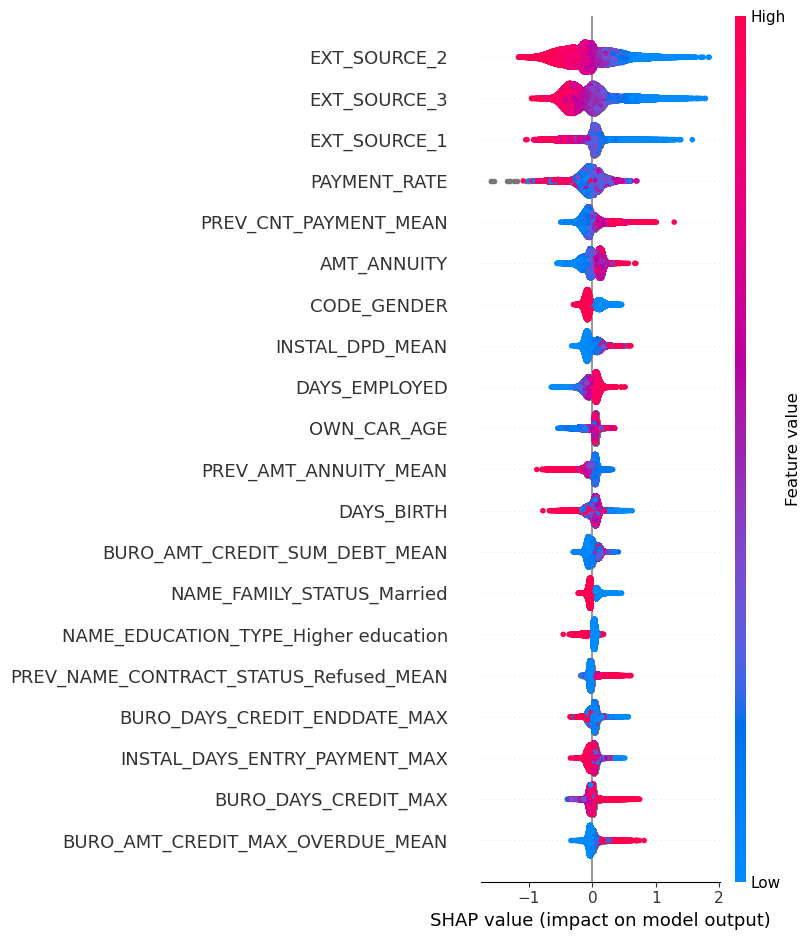

In [27]:
import shap

explainer = shap.TreeExplainer(best_model)

# Calcul des valeurs SHAP (peut prendre du temps selon la taille du jeu de données)
shap_values = explainer.shap_values(X_train)

# Résumé de l'impact des caractéristiques
shap.summary_plot(shap_values, X_train, feature_names=feature_names)

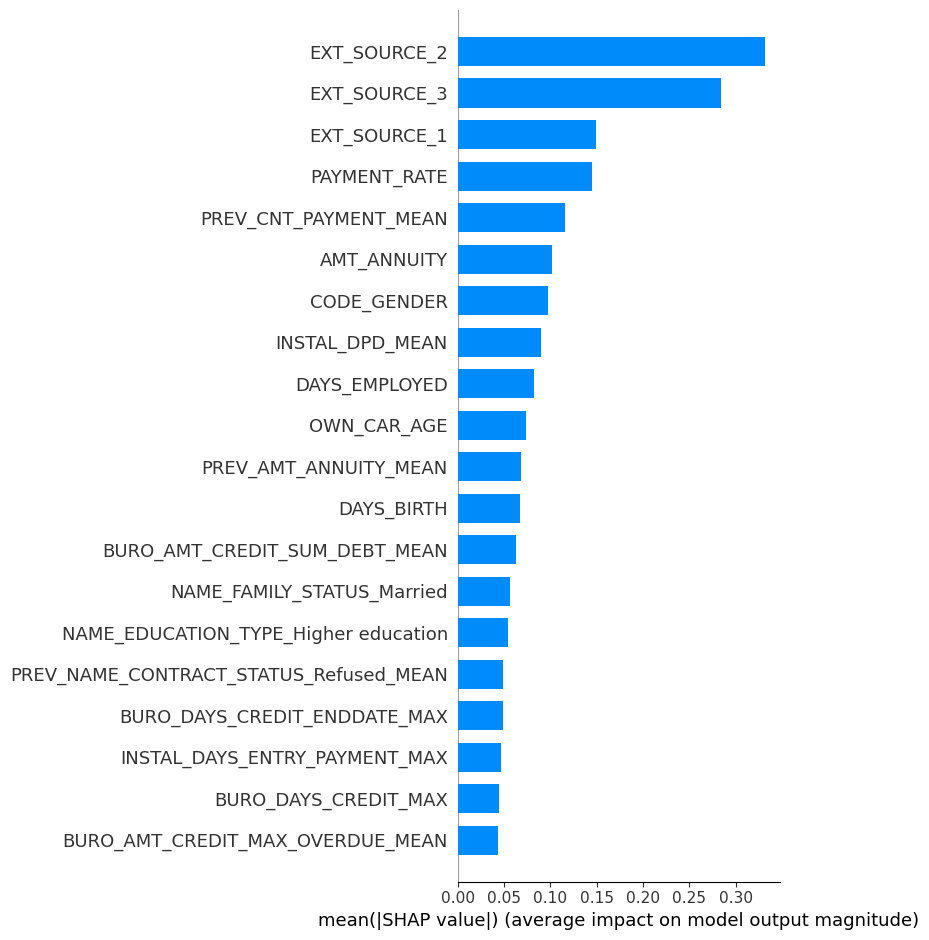

In [28]:
shap.summary_plot(shap_values, X_train, feature_names=feature_names, plot_type="bar")

In [30]:
# impact des caractéristiques pour une seule prédiction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:], feature_names=feature_names)

In [31]:
from joblib import dump

# Sauvegarde du meilleur modèle
path_models = '../models/'
dump(best_model, path_models + 'best_model_v1.joblib')

# Pour charger le modèle plus tard
# from joblib import load
# loaded_model = load('best_model.joblib')

['../models/best_model_v1.joblib']